In [153]:
import pandas as pd
import numpy as np
import re
import ast
from statsmodels.stats.proportion import proportion_confint
import matplotlib.ticker as mticker
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt


# file1 = "all_papers_labeled_2017_2018.csv"
# file2 = "all_papers_labeled_2019_2021.csv"
# file3 = "all_papers_labeled_2022_2024.csv"

# df1 = pd.read_csv(file1)
# df2 = pd.read_csv(file2)
# df3 = pd.read_csv(file3)

# data = pd.concat([df1, df2, df3], ignore_index=True)

# len_before_processing = len(data)

# filtered_data = data[data['language'] == 'en']

# #  "soccer" or "football" in the abstract
# filtered_data['mention_count'] = filtered_data['abstract'].str.count(r'\bsoccer\b|\bfootball\b', flags=re.IGNORECASE)

# #  "soccer" or "football" is mentioned in the title
# filtered_data['title_match'] = filtered_data['title'].str.contains(r'\bsoccer\b|\bfootball\b', flags=re.IGNORECASE)

# def filter_concepts(concepts_column):
#     concepts_list = ast.literal_eval(concepts_column) if isinstance(concepts_column, str) else concepts_column
#     return any(
#         ('football' in concept['display_name'].lower() or 'soccer' in concept['display_name'].lower()) 
#         and concept['score'] > 0.2 
#         for concept in concepts_list
#     )

# filtered_data['concepts_match'] = filtered_data['concepts'].apply(filter_concepts)

# filtered_data['keep'] = (
#     (filtered_data['mention_count'] > 2) |  # At least 2 mentions in the abstract
#     (filtered_data['concepts_match']) |      # Match in the concepts with score > 0.2
#     (filtered_data['title_match'])           # Mention in the title
# )
# filtered_data = filtered_data[filtered_data['keep']==True]
# filtered_data.to_csv("filtered_data.csv", index=False)
# print(f"Kept {int((len(filtered_data)/len_before_processing)*100)}% of original data")

# Preparing data to VosViewer

In [154]:
# import json
# import ast  # For safely evaluating the string into a Python object
# import math
# data_copy = data.copy()
# # data = data.sort_values("cited_by_count", ascending=False)
# # top_10_percent_idx = max(int(len(data) * 0.13), 1)
# # top_20_percent_idx = max(int(len(data) * 0.14), top_10_percent_idx+1)
# # data_copy = data.iloc[top_10_percent_idx:top_20_percent_idx]

# my_export = {
#     "results": []
# }

# # List of columns that might contain nested JSON strings
# nested_columns = [
#     "authorships", "referenced_works", "concepts", "primary_location",
#     "counts_by_year", "biblio", "related_works", "abstract_inverted_index",
#     "institution_assertions", "best_oa_location", "datasets", "sustainable_development_goals",
#     "mesh", "grants", "indexed_in", "topics", "locations"
# ]

# def replace_nan(value, column):
#     # Convert "NaN" string to None as well
#     if isinstance(value, str) and value.strip().lower() == "nan":
#         return None 
#     if isinstance(value, float) and math.isnan(value):
#         return None
#     elif isinstance(value, list):
#         return [replace_nan(v, column) for v in value]
#     elif isinstance(value, dict):
#         return {k: replace_nan(v, column) for k, v in value.items() if replace_nan(v, column) is not None}
#     return value

# def parse_nested_json(raw_value):
#     if raw_value and isinstance(raw_value, str):
#         try:
#             # Safely parse the string to a Python list/dict
#             return ast.literal_eval(raw_value)
#         except Exception as e:
#             print(f"Error parsing value: {e}")
#             return None  # Default to None if parsing fails
#     return raw_value

# for index, row in data_copy.iterrows():
#     record = {}
#     for column in data_copy.columns:
#         raw_value = row.get(column, None)
#         if column in nested_columns:
#             parsed_value = parse_nested_json(raw_value)
#             record[column] = replace_nan(parsed_value, column)
#         else:
#             record[column] = replace_nan(raw_value, column)
#     my_export["results"].append(record)

# # Save to JSON file
# with open("../data/VosViewer.json", "w") as json_file:
#     json.dump(my_export, json_file, indent=4)

# # Print unique "id" count
# unique_ids_count = data_copy['id'].value_counts().sum()
# print(unique_ids_count)

In [155]:
data = pd.read_csv("filtered_data.csv")
# data = filtered_data[(filtered_data['cited_by_count'] >= 14) & (filtered_data['cited_by_count'] < 15)]
data_export = pd.read_csv("../data/data_export.csv")

In [156]:
# Merge the dataframes on 'id'
merged_data = data.merge(data_export[['id', 'authors', 'journal_name', 'countries']], on='id', how='left')

# Inserting category into mappings

### 1. Authors

In [157]:
# Split authors so only 1 author per row
merged_data['authors'] = merged_data['authors'].apply(lambda x: x.replace("'", "").replace("[", "").replace("]", "").lower().split(', '))
merged_data = merged_data.explode('authors')

# Get most frequent category per author
df_categories = merged_data.groupby('authors')['predicted_category'] \
    .agg(lambda x: x.value_counts().index[0]) \
    .reset_index()

# Map string categories to integers
category_map = {
    "Psychology": 7, "Innovative Technologies": 1, "Physical Attributes": 2, "Scouting / Finance": 3,
    "Other": 4, "Medical / Injuries": 5, "Tactics analysis": 6
}

df_categories['category_int'] = df_categories['predicted_category'].map(category_map)

# Rename columns
df_categories = df_categories.rename(columns={'authors': 'author_name', 'predicted_category': 'category'})

df_categories.to_csv("author_categories.csv", index=False)

### 2. Journals

In [158]:
# # Split journal names so only 1 journal name per row
# merged_data['journal_name'] = merged_data['journal_name'].apply(lambda x: str(x).replace("'", "").replace("[", "").replace("]", "").lower().split(', ') if isinstance(x, str) else [])
# merged_data = merged_data.explode('journal_name')

# # Get most frequent category per journal name
# df_categories = merged_data.groupby('journal_name')['predicted_category'] \
#     .agg(lambda x: x.value_counts().index[0]) \
#     .reset_index()

# # Map string categories to integers
# category_map = {
#     "Psychology": 7, "Innovative Technologies": 1, "Physical Attributes": 2, "Scouting / Finance": 3,
#     "Other": 4, "Medical / Injuries": 5, "Tactics analysis": 6
# }

# df_categories['category_int'] = df_categories['predicted_category'].map(category_map)

# # Rename columns
# df_categories = df_categories.rename(columns={'journal_name': 'journal_name', 'predicted_category': 'category'})

# df_categories.to_csv("journal_categories.csv", index=False)

### 3. Countries

In [159]:
# # Split countries so only 1 country per row
# merged_data['countries'] = merged_data['countries'].apply(lambda x: x.replace("'", "").replace("[", "").replace("]", "").lower().split(', '))
# merged_data = merged_data.explode('countries')

# # Get most frequent category per country
# df_categories = merged_data.groupby('countries')['predicted_category'] \
#     .agg(lambda x: x.value_counts().index[0]) \
#     .reset_index()

# # Map string categories to integers
# category_map = {
#     "Psychology": 7, "Innovative Technologies": 1, "Physical Attributes": 2, "Scouting / Finance": 3,
#     "Other": 4, "Medical / Injuries": 5, "Tactics analysis": 6
# }

# df_categories['category_int'] = df_categories['predicted_category'].map(category_map)

# # Rename columns
# df_categories = df_categories.rename(columns={'countries': 'country_name', 'predicted_category': 'category'})

# df_categories.to_csv("country_categories.csv", index=False)

### Inserting into map csv

In [220]:

# Load map.csv
map_df = pd.read_csv("maps_and_networks/map_top300_authors.csv")

# Merge df_categories with map_df on country_name and label
merged_df = map_df.merge(df_categories, left_on='label', right_on='author_name', how='left')

# Replace cluster with category_int
merged_df['cluster'] = merged_df['category_int']

# Drop unnecessary columns
merged_df = merged_df.drop(columns=['author_name', 'category', 'category_int'])

# # Save the updated map.csv
merged_df.to_csv("map_updated.csv", index=False)

In [161]:
merged_df['cluster'].isna().sum()


1

# Visuals

### 1. Citation average in each category

In [162]:
category_citation_stats = merged_data.groupby('predicted_category')['cited_by_count'] \
    .mean() \
    .sort_values(ascending=False)

print(category_citation_stats)

predicted_category
Tactics analysis           12.920598
Medical / Injuries         11.834133
Psychology                 11.077590
Physical Attributes        10.596487
Innovative Technologies     9.242659
Scouting / Finance          7.579434
Other                       7.229124
Name: cited_by_count, dtype: float64


In [163]:
category_citation_stats = merged_data.groupby('predicted_category')['cited_by_count'] \
    .sum() \
    .sort_values(ascending=False)

print(category_citation_stats)

predicted_category
Physical Attributes        284717
Medical / Injuries         165311
Innovative Technologies     66732
Tactics analysis            50119
Psychology                  47257
Scouting / Finance          38549
Other                       17574
Name: cited_by_count, dtype: int64


In [164]:
import os
import pandas as pd

# Paths
# List files in the directory to verify paths
base_path = "maps_and_networks"
map_file = os.path.join(base_path, "map_all_authors.csv")
net_file = os.path.join(base_path, "network_all_authors.csv")
cat_file = "author_categories.csv"

# 1. Load author–ID map
df_map = pd.read_csv(map_file)  # columns: author_id, author_name

# 2. Merge with author_categories
df_cat = pd.read_csv(cat_file)  # columns: author_name, category
df_author_cat = df_map.merge(df_cat, left_on="label", right_on="author_name", how="left")

# 3. Load network and merge with author–category
df_net = pd.read_csv(net_file, header=None, names=["author_id_1", "author_id_2", "link_strength"])
df_author_cat = df_author_cat.rename(columns={'id': 'author_id'})


df_net_cat = df_net \
    .merge(df_author_cat[["author_id", "category"]], left_on="author_id_1", right_on="author_id", how="left") \
    .rename(columns={"category": "category_1"}) \
    .drop(columns="author_id")
df_net_cat = df_net_cat \
    .merge(df_author_cat[["author_id", "category"]], left_on="author_id_2", right_on="author_id", how="left") \
    .rename(columns={"category": "category_2"}) \
    .drop(columns="author_id")

df_net_cat['category_1'] = df_net_cat['category_1'].fillna('Unknown').astype(str)
df_net_cat['category_2'] = df_net_cat['category_2'].fillna('Unknown').astype(str)
# 4. Count collaborations by category pair
df_net_cat = df_net_cat[df_net_cat['category_1'] != 'Unknown']
df_net_cat = df_net_cat[df_net_cat['category_2'] != 'Unknown']

# 4. Count collaborations by ordered category pair
df_net_cat['ordered_pair'] = df_net_cat.apply(
    lambda row: tuple(sorted([row['category_1'], row['category_2']])), axis=1
)




df_collab = df_net_cat.groupby('ordered_pair').size().reset_index(name='collaborations')
df_collab['collaborations'] = df_collab['collaborations']
df_collab[['category_1', 'category_2']] = pd.DataFrame(df_collab['ordered_pair'].tolist(), index=df_collab.index)
df_collab = df_collab.drop(columns='ordered_pair')
df_collab = df_collab.sort_values(by="collaborations", ascending=False)

df_collab['category_1_contribution'] = df_collab.apply(
    lambda row: row['collaborations'], axis=1
)
df_collab['category_2_contribution'] = df_collab.apply(
    lambda row: row['collaborations'] if row['category_1'] != row['category_2'] else 0, axis=1
)

# Prepare a long-form dataframe to sum by categories
df_long = pd.concat([
    df_collab[['category_1', 'category_1_contribution']].rename(
        columns={'category_1': 'category', 'category_1_contribution': 'contribution'}),
    df_collab[['category_2', 'category_2_contribution']].rename(
        columns={'category_2': 'category', 'category_2_contribution': 'contribution'})
])

# Group by category and sum contributions
df_total_collab = df_long.groupby('category')['contribution'].sum().reset_index()
df_total_collab = df_total_collab.rename(columns={'contribution': 'total_collaborations'})

# Sort by total collaborations for clarity
df_total_collab = df_total_collab.sort_values(by='total_collaborations', ascending=False)

# for each row in df_collab find percentage compared to total collaborations for both categories
df_collab = df_collab.merge(df_total_collab, left_on='category_1', right_on='category', how='left') \
    .rename(columns={'total_collaborations': 'total_collaborations_1'}) \
    .drop(columns='category')
df_collab = df_collab.merge(df_total_collab, left_on='category_2', right_on='category', how='left') \
    .rename(columns={'total_collaborations': 'total_collaborations_2'}) \
    .drop(columns='category')

df_collab['category_1_percentage'] = df_collab.apply(
    lambda row: row['category_1_contribution'] / row['total_collaborations_1'], axis=1
)
df_collab['category_2_percentage'] = df_collab.apply(
    lambda row: row['category_2_contribution'] / row['total_collaborations_2'], axis=1
)

df_collab.head()




,collaborations,category_1,category_2,category_1_contribution,category_2_contribution,total_collaborations_1,total_collaborations_2,category_1_percentage,category_2_percentage
0,23833,Physical Attributes,Physical Attributes,23833,0,32066,32066,0.743248,0.000000
1,10816,Medical / Injuries,Medical / Injuries,10816,0,15901,15901,0.680209,0.000000
2,3774,Medical / Injuries,Physical Attributes,3774,3774,15901,32066,0.237344,0.117695
3,1775,Physical Attributes,Tactics analysis,1775,1775,32066,3827,0.055355,0.463810
4,1717,Psychology,Psychology,1717,0,4281,4281,0.401075,0.000000


In [165]:
# Get unique categories
unique_categories = df_net_cat['category_1'].unique()

# Initialize an empty list to store results
results = []

# Loop through each category
for cat_name in unique_categories:
    # 1) Filter to pairs where this category is involved
    df_physical = df_net_cat[
        (df_net_cat['category_1'] == cat_name) |
        (df_net_cat['category_2'] == cat_name)
    ]

    # 2) Count total collabs for the current category only
    total_for_physical = len(df_physical)  # or sum link_strength if you want weighting

    # 3) Group by the *other* category to see distribution
    df_physical_dist = (
        df_physical.assign(
            other_category=lambda d: d.apply(
                lambda row: row['category_2'] if row['category_1'] == cat_name else row['category_1'],
                axis=1
            )
        )
        .groupby('other_category')
        .size()
        .reset_index(name='collaborations')
    )

    # 4) Compute fraction
    df_physical_dist['fraction_of_total'] = (
        df_physical_dist['collaborations'] / total_for_physical
    )

    # Add the category name to the dataframe
    df_physical_dist['category'] = cat_name

    # Append the result to the list
    results.append(df_physical_dist)

# Concatenate all results into a single dataframe
df_all_categories = pd.concat(results, ignore_index=True)


df_all_categories.head(10)


,other_category,collaborations,fraction_of_total,category
0,Innovative Technologies,180,0.042046,Psychology
1,Medical / Injuries,635,0.148330,Psychology
2,Other,46,0.010745,Psychology
3,Physical Attributes,1221,0.285214,Psychology
4,Psychology,1717,0.401075,Psychology
5,Scouting / Finance,233,0.054427,Psychology
6,Tactics analysis,249,0.058164,Psychology
7,Innovative Technologies,729,0.022734,Physical Attributes
8,Medical / Injuries,3774,0.117695,Physical Attributes
9,Other,132,0.004117,Physical Attributes


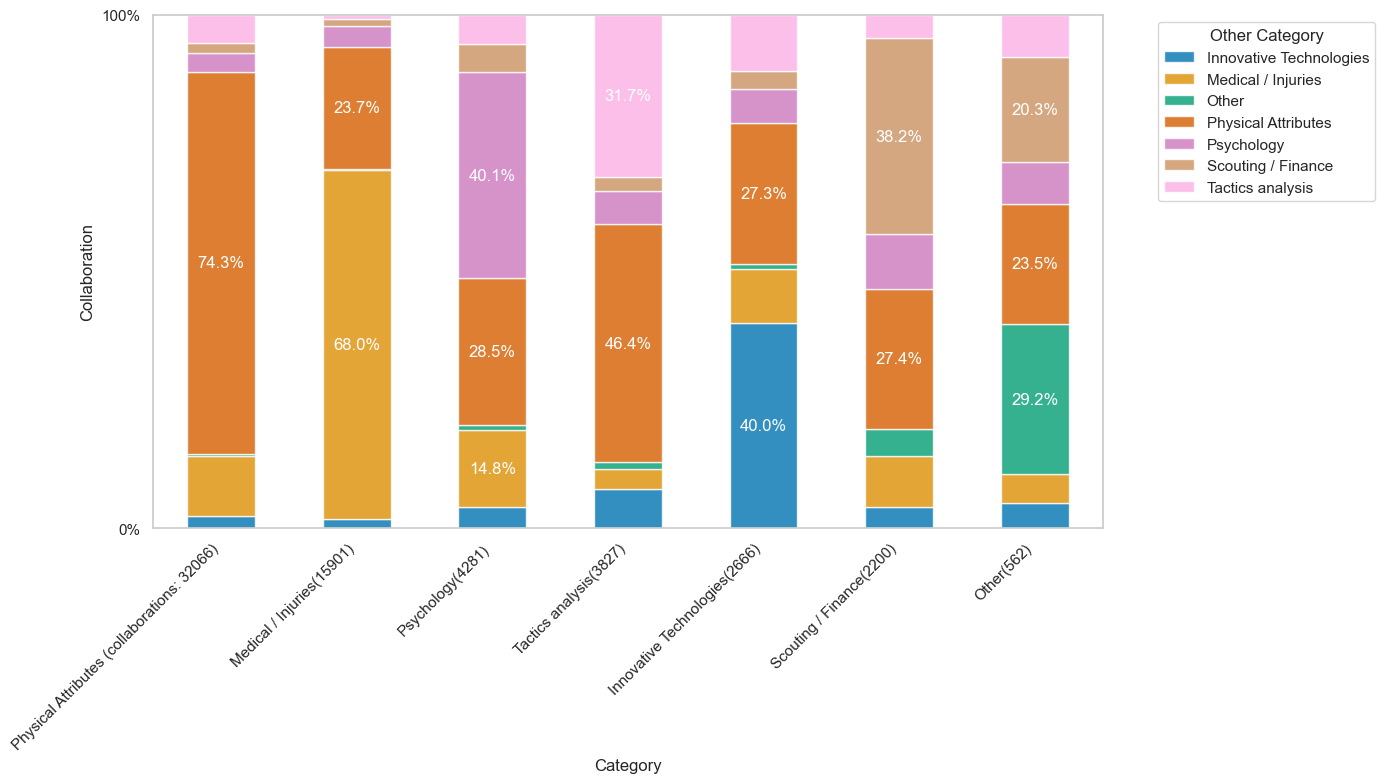

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# 1) Pivot so rows are 'category' and columns are 'other_category' 
df_stacked = df_all_categories.pivot(
    index='category',
    columns='other_category',
    values='fraction_of_total'
)

# Generate the color palette
colors = sns.color_palette("colorblind", len(df_stacked.columns))

# Calculate total collaboration for each category from df_all_categories
collab_sums = df_all_categories.groupby('category')['collaborations'].sum().sort_values(ascending=False)

# Reorder df_stacked based on sorted collab_sums
df_stacked = df_stacked.loc[collab_sums.index]

# 2) Convert fractions to percentages
df_stacked_percent = df_stacked * 100

# Plot as a stacked bar chart
ax = df_stacked_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=colors,
    alpha=0.8
)

# 3) Format the plot
ax.set_xlabel("Category")
ax.set_ylabel("Collaboration")
plt.ylim(0, 100)  # ensure y-axis goes from 0 to 100 for percentage

# Add percentage sign to y-ticks
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.yticks(np.arange(0, 101, 100))
plt.xticks(rotation=45, ha='right')
plt.legend(title='Other Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Remove grid
ax.grid(False)

# Add labels inside the bars if they are above 12% (converted to 12 for percentages)
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.1f}%' if v > 12 else '' for v in container.datavalues], label_type='center', color='white')

# Update x-axis labels to include total collaboration
new_labels = [
    f'{category} (collaborations: {collab_sums.get(category, 0)})' if idx == 0 else f'{category}({collab_sums.get(category, 0)})'
    for idx, category in enumerate(df_stacked.index)
]
ax.set_xticklabels(new_labels)

plt.tight_layout()
plt.savefig("co-author_percent.jpg", dpi=400)
plt.show()

/var/folders/12/sch4w1bj79q33lp95mcccx700000gn/T/ipykernel_84507/1314082864.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return data.applymap(lambda x: f'{x:.2f}%')


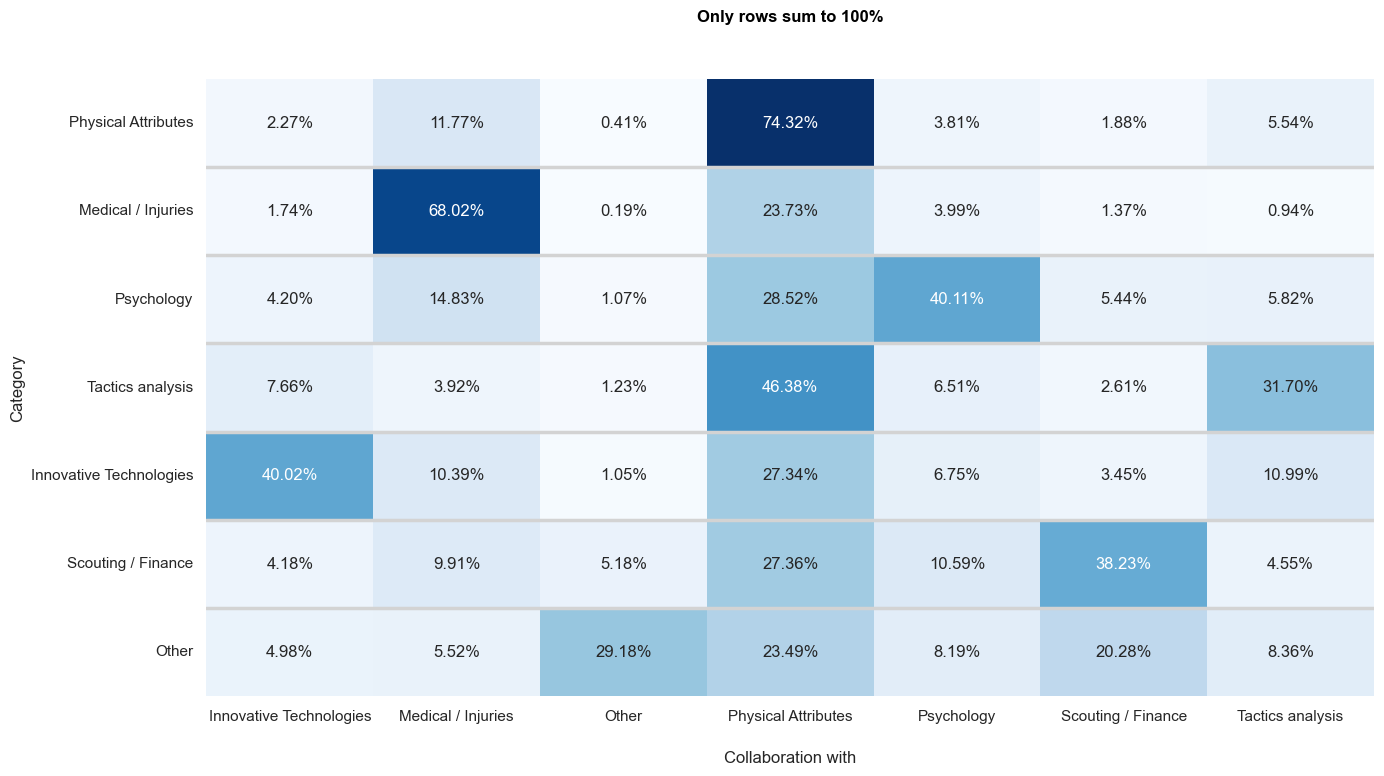

In [218]:
df_normalized = df_stacked.div(df_stacked.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))

# Custom annotation function to add percentage sign
def annot_format(data):
    return data.applymap(lambda x: f'{x:.2f}%')

ax = sns.heatmap(df_normalized, cmap="Blues", annot=annot_format(df_normalized), fmt="", cbar=False)
plt.xlabel("Collaboration with", labelpad=20)  # Increase labelpad to move xlabel down
plt.ylabel("Category")
plt.yticks(rotation=0)
plt.tight_layout()

for i in range(1, df_normalized.shape[0]):
    ax.axhline(i, color='lightgrey', lw=2.5)

plt.text(len(df_normalized.columns) / 2, -0.7, 'Only rows sum to 100%', ha='center', va='center', fontsize=12, color='black', fontweight='bold')
plt.tight_layout()
plt.savefig("co-author_percent.jpg", dpi=400)
plt.show()